<a href="https://colab.research.google.com/github/Swap-01/Networking-/blob/main/DL_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 170M/170M [00:08<00:00, 20.3MB/s]
/tmp/ipython-input-3946449083.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="Set2")


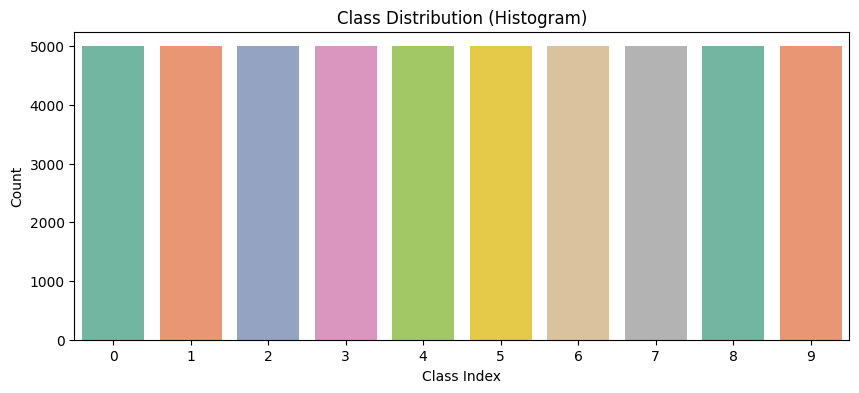

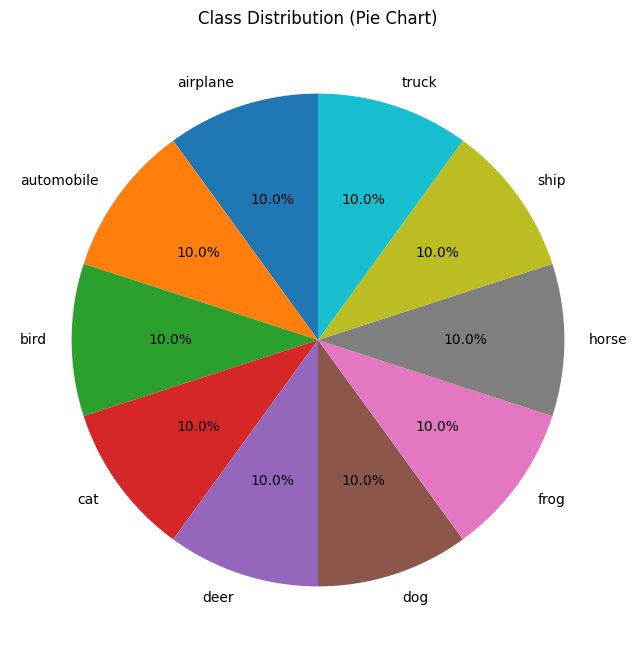

Epoch [1/20], Train Acc: 48.05%, Val Acc: 57.56%
Epoch [2/20], Train Acc: 62.20%, Val Acc: 66.15%
Epoch [3/20], Train Acc: 66.14%, Val Acc: 66.12%
Epoch [4/20], Train Acc: 69.20%, Val Acc: 68.55%
Epoch [5/20], Train Acc: 71.22%, Val Acc: 68.64%
Epoch [6/20], Train Acc: 73.34%, Val Acc: 69.83%
Epoch [7/20], Train Acc: 75.42%, Val Acc: 71.60%
Epoch [8/20], Train Acc: 76.89%, Val Acc: 71.85%
Epoch [9/20], Train Acc: 78.18%, Val Acc: 71.78%
Epoch [10/20], Train Acc: 79.66%, Val Acc: 73.26%
Epoch [11/20], Train Acc: 80.86%, Val Acc: 71.55%
Epoch [12/20], Train Acc: 81.85%, Val Acc: 71.86%
Epoch [13/20], Train Acc: 83.24%, Val Acc: 72.09%
Epoch [14/20], Train Acc: 83.97%, Val Acc: 71.28%
Epoch [15/20], Train Acc: 84.73%, Val Acc: 71.03%
Epoch [16/20], Train Acc: 85.23%, Val Acc: 70.96%
Epoch [17/20], Train Acc: 86.20%, Val Acc: 71.23%
Epoch [18/20], Train Acc: 86.80%, Val Acc: 71.65%
Epoch [19/20], Train Acc: 87.48%, Val Acc: 70.98%
Epoch [20/20], Train Acc: 88.09%, Val Acc: 71.16%

Test Set

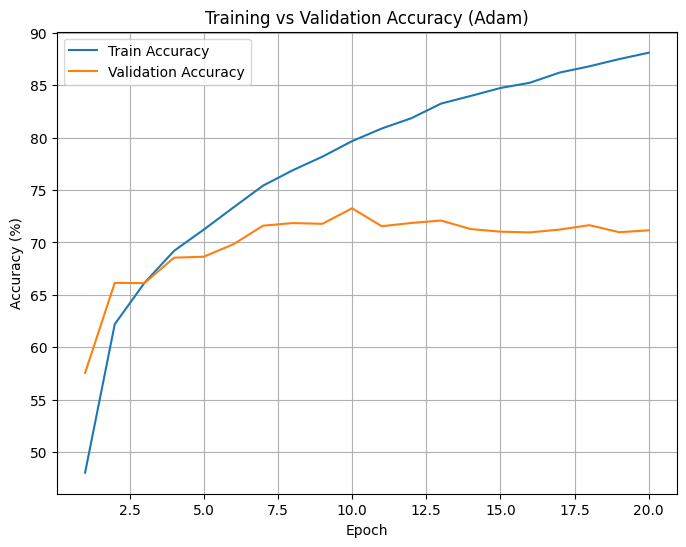

In [ ]:
# ================================
# CIFAR-10 CNN Classification - PyTorch
# Ready for Google Colab
# ================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# --------------------------------
# 1. Device configuration
# --------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------------
# 2. Load and Transform CIFAR-10
# --------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split into train/validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [train_size, val_size])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = train_set.classes

# --------------------------------
# 3. Visualize Class Distribution
# --------------------------------
train_labels = [train_set[i][1] for i in range(len(train_set))]

plt.figure(figsize=(10,4))
sns.countplot(x=train_labels, palette="Set2")
plt.title("Class Distribution (Histogram)")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

# Pie Chart
counts = np.bincount(train_labels)
plt.figure(figsize=(8,8))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution (Pie Chart)")
plt.show()

# --------------------------------
# 4. CNN Model Definition
# --------------------------------
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64*8*8, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# --------------------------------
# 5. Training Function
# --------------------------------
def train_model(optimizer_type="adam", num_epochs=20):
    model = CNNModel(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total

        # Validation accuracy
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total

        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

    return model, train_acc_history, val_acc_history

# --------------------------------
# 6. Train with Adam
# --------------------------------
model_adam, train_acc_adam, val_acc_adam = train_model(optimizer_type="adam", num_epochs=20)

# --------------------------------
# 7. Evaluate on Test Set
# --------------------------------
def evaluate_model(model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    print("\nTest Set Evaluation:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {weighted_f1:.4f}")
    print(f"F1 Score (macro): {macro_f1:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

evaluate_model(model_adam)

# --------------------------------
# 8. Plot Training vs Validation Accuracy
# --------------------------------
plt.figure(figsize=(8,6))
plt.plot(range(1, 21), train_acc_adam, label="Train Accuracy")
plt.plot(range(1, 21), val_acc_adam, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy (Adam)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------
# 9. Optional: Train with RMSprop for comparison
# --------------------------------
# model_rms, train_acc_rms, val_acc_rms = train_model(optimizer_type="rmsprop", num_epochs=20)
# evaluate_model(model_rms)